# Introducrtion to Machine Learning: Assignment #4
## Submission date: 21\03\2024, 23:55.
### Topics:
- PCA
- K means clustering
- AdaBoost

**Assignment Instruction:**

· Submissions in pairs only.

· The code must be reasonably documented

· Try to keep the code as clean, concise, and short as possible

· Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to disciplinary actions.

· You should save a copy of the notebook to your Drive and answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

· If you wish to work in your IDE, make a `.py` copy of the notebook, but as you finish insert the script back to the matching cells of the notebook.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).

## Question 1 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [ ]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))
		# Implement here
		for i in range (self.n_clusters):
			mask=labels==i
			centroids[i]=X[mask].mean(axis=0)
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids
			# For each point, calculate distance to all k clustes.
			distance = self.compute_distance(X, old_centroids)
			self.labels =	self.find_closest_cluster(distance)  # Assign the labels with closest distance' cluster.
			self.centroids = self.reassign_centroids(X, self.labels)  # Update the centroids
			if np.all(old_centroids == self.centroids):
				break
		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Load exams data, convert to numpy and plot it. <br/>
The data can be found here: https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv

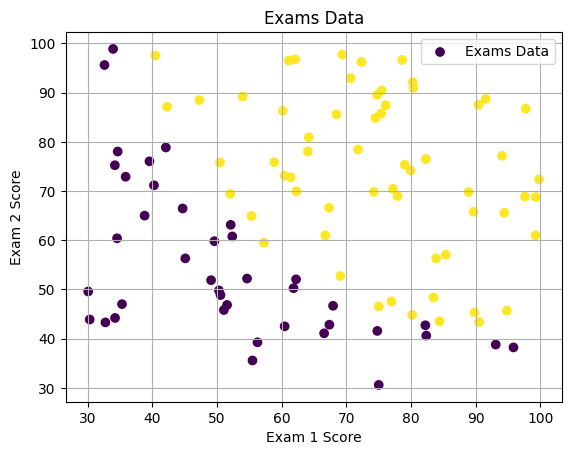

In [ ]:
# Implement here
data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv',header=None)
numpy_data = data.to_numpy()
data=numpy_data

# Plot the data
plt.scatter(numpy_data[:, 0], numpy_data[:, 1], c=numpy_data[:, 2], cmap='viridis', marker='o', label='Exams Data')
plt.title('Exams Data')
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.legend(loc='upper right')
plt.grid()
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

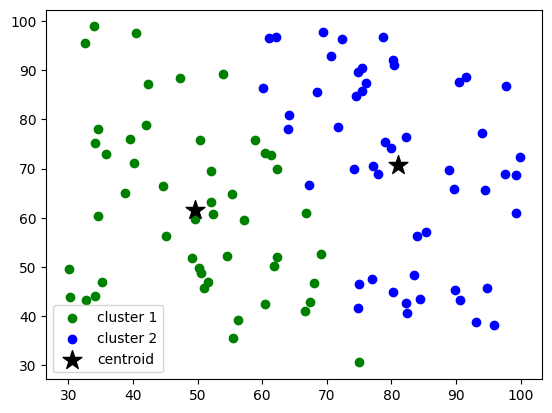

In [ ]:
# Implement here
clust = Kmeans(n_clusters=2)
clust.fit(numpy_data[:, :2])
labels = clust.predict(numpy_data[:, :2])
# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='Green'>Based on the graph result below, k=5 is the elbow point which gives the graph its characteristic elbow shape.</font>

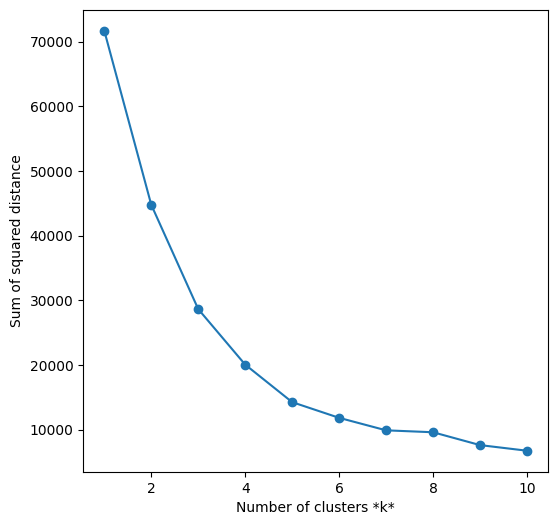

In [ ]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
  clust = Kmeans(n_clusters=k)
  clust.fit(numpy_data[:, :2])
  sse.append(clust.error)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

In [ ]:
# Implement here
clust = Kmeans(n_clusters=5)
clust.fit(numpy_data[:, :2])

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


### helper function

In [ ]:
import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

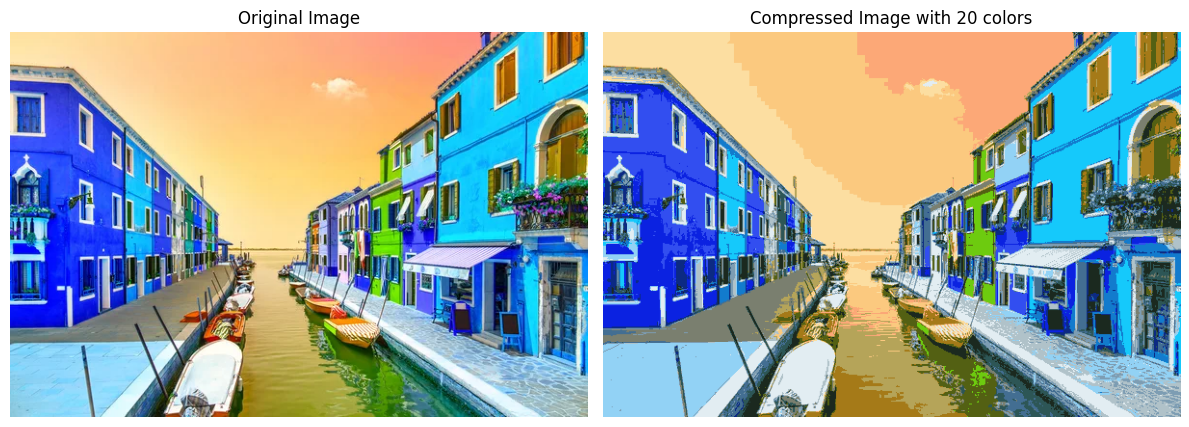

In [ ]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

#Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
# Use cluster_centers_ and labels_
X_compressed = km.cluster_centers_[km.labels_]
img_compressed = X_compressed.reshape(img_size[0] * img_size[1], img_size[2])
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

# Plot the original and the compressed image next to each other'''
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(img_compressed)
ax[1].set_title(f'Compressed Image with {km.n_clusters} colors')

for ax in fig.axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Question 2 - AdaBoost
See attached pdf in moodle assignment!

## load smiling dataset

In the rest of the assignment, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. <br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The algorithm expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                        Online Food Dataset                                  3KB  2024-03-02 18:50:30          13875        276  0.9411765        
bhavikjikadara/student-study-performance                   Student Study Performance                            9KB  2024-03-07 06:14:09           7210        108  1.0              
lovishbansal123/sales-of-a-supermarket                     Sales of a Supermarket                              36KB  2024-03-26 12:38:06           1212         27  1.0              
syedanwarafridi/vehicle-sales-data                      

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
  image_arrays = []
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    image = cv2.imread(file_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_arrays.append(gray_image)
  return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
labels = np.concatenate((np.ones(smile.shape[0]),np.zeros(non_smile.shape[0])))

display smiling and non-smiling image.

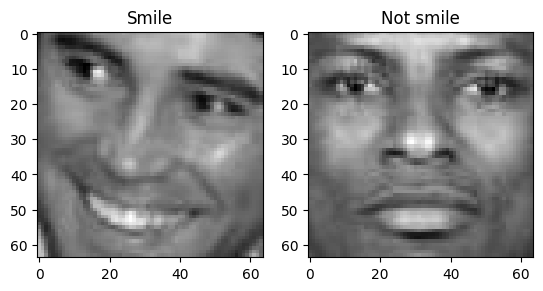

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA

import libraries

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one.

In [ ]:
def PCA_train(data, k):
    # 1. Compute the mean of the data
    mu = np.mean(data, axis=0)
    # 2. Subtract the mean from the data
    Z = data - mu
    # 3. Compute the covariance matrix
    S = np.cov(Z, rowvar=False)
    # 4. Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(S)
    # 5. Convert any small negative eigenvalues to zero
    eigenvalues = np.maximum(eigenvalues, 0)
    # 6. Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    # 7. Select the top k eigenvectors
    E = eigenvectors[:, :k]
    # 8. Project the centered data onto the top k eigenvectors to get the principal components
    data_pca = np.dot(Z, E)
    return data_pca, mu, E, eigenvalues

def PCA_test(test, mu, E):
  # 1. Subtract the mean from the data
  Z = test - mu
  # 2. Transform the data into the new subspace
  test_pca = (np.dot(Z, E))
  return test_pca

def recover_PCA(data, mu, E):
	# 1. Transform the data back to the original space
  org_data = np.dot(data, E.T)
  # 2. Add the mean back to the data
  org_data += mu
  return org_data

Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [ ]:
k = 81
x_train_new, mu, eig, eig_vals = PCA_train(x_train_flatten, k)
x_test_new = PCA_test(x_test_flatten, mu, eig)

Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

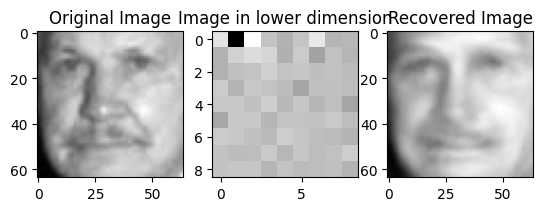

In [ ]:
random_index=170
random_image = x_test[random_index]
low_dimention_image=x_test_new[random_index]
#recover image
recovered_image = recover_PCA(low_dimention_image, mu, eig)

plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(low_dimention_image.reshape(9,9), cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image.reshape(64,64), cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

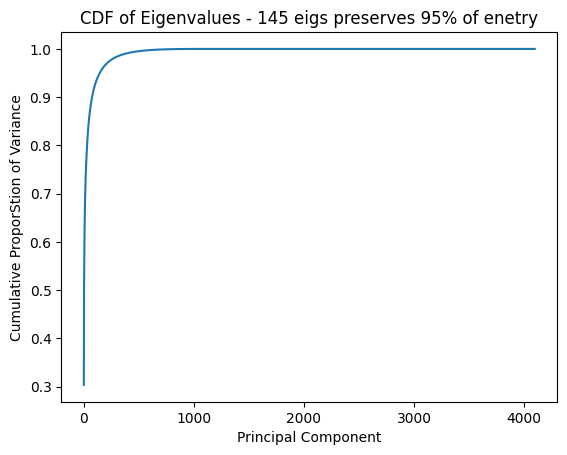

In [ ]:
def EIG_CDF(eig_list):
 sorted_eigenvalues = np.sort(eig_list)[::-1]
 eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)
 eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]

 amount = np.argmax(eigenvalues_cumsum_normalized>0.95)


 plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
 plt.xlabel('Principal Component')
 plt.ylabel('Cumulative ProporStion of Variance')
 plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
 plt.show()

# Call to EIG_CDF
EIG_CDF(eig_vals)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='GREEN'>After running the EIG_CDF function and analyzing the obtained graph, it was observed that 145 eigs were able to preserve 95% of the image data. The closest square number to 145 is 144 (12x12), which is the perfect dimension for the dataset. When comparing the results of 81 and 144 dimensions, it was found that images obtained from 144 dimensions were clearer and less blurry. Small details such as the line of the cheeks, which were not visible in 81 dimensions, are now visible in 144 dimensions.</font>

In [ ]:
x_train_new2, mu2, eig2, eig_vals2 = PCA_train(x_train_flatten,144)
x_test_new2 =PCA_test(x_test_flatten,mu2,eig2)

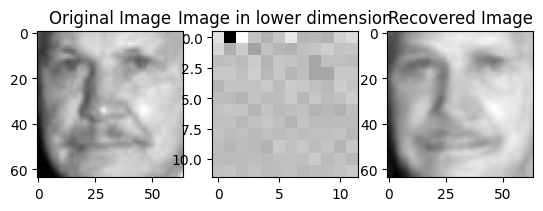

In [ ]:
plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(x_test_new2[random_index].reshape(12,12), cmap='gray')

#recover image
recovered_image2 = recover_PCA(x_test_new2[random_index], mu2, eig2)

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image2.reshape(64,64), cmap='gray')

plt.show()

Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

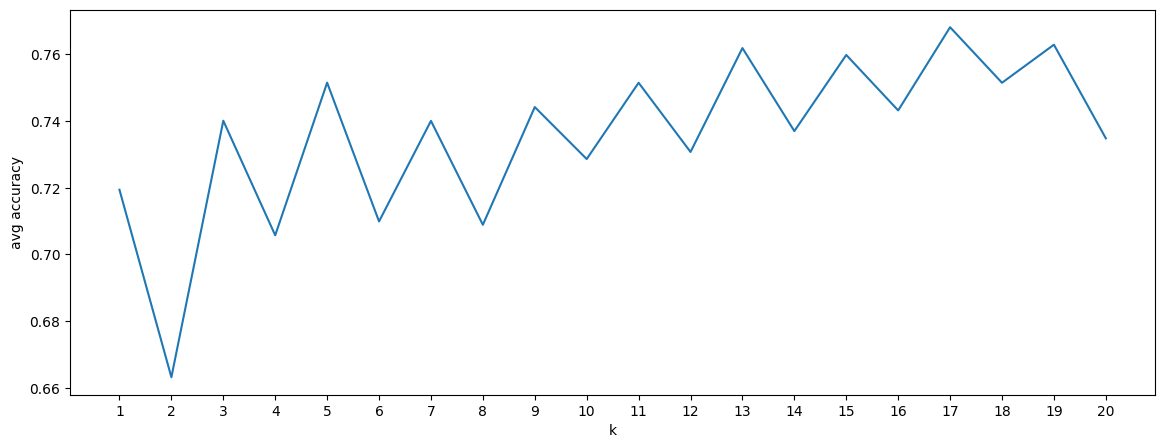

In [ ]:
ks = np.arange(1, 21)
accs = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_new, y_train, cv=10, scoring='accuracy')
    accs.append(scores.mean())

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [ ]:
best_k = ks[np.argmax(accs)-1]
acc = accs[best_k]
print(f'acc on test is {acc}')

acc on test is 0.7681056701030928


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Give two reasons for not applying Standard Scaler on this task.
- Recall the KNN is using euclidian distance metric. Is it possible that switching distance metric will yield better result? What distance metric?
<font color='Green'> <br/>
- During the implementation of PCA, we performed three major preprocessing steps: calculating mean and mean centering (steps 1 and 2 in the code), calculating the covariance matrix (step 3 in the code), and decomposing the covariance matrix to calculate eigenvectors and eigenvalues.
-  There are two reasons why we should avoid applying Standard Scaler to our data. Firstly, Standard Scaler performs mean centering on the data, which we have already accomplished. Applying Standard Scaler again would simply duplicate this step, leading to inaccurate calculations. Secondly, since our data consists of images, which may contain outlier pixel values, Standard Scaler is sensitive to these outliers, which can result in noise and artifacts.
- In theory, the Manhattan distance metric is a better option. However, the effectiveness of switching to this metric depends on the specific characteristics of the images analyzed. The Euclidean distance metric is simple and calculates distances without considering any relationships between pixels. In contrast, the Manhattan distance metric considers the relationships between pixels when calculating distances.
 </font>


## Question 4 - 10 points bonus

4 points - Use KNN with the metric that you answered that will be the best. Find the best possible k and print the accuracy test.

In [ ]:
# Input: x, y with d features.
# Output: the distance between them by the chosen metric.

def Your_Metric(x, y):
  # Implement here

Print the accuracy of your model on the test set. Were you correct? If no, why do you think it happened? What else could be done? <br/>

<font color='red'>Write here your answer</font>

In [ ]:
# Implement here
print(f'acc on test is {acc}')

6 points - make the best model that you can, using all the models we have seen through this course. <br/>
<font color='red'>Write here all your decisions you made and the motivation behind them.</font>

In [ ]:
# Implement here